In [1]:
!pip install -q diffusers==0.30.0 transformers accelerate safetensors ftfy
!pip install -q "torch>=2.0" "torchvision"
!pip install -q pillow pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00


In [2]:
import os
import torch
from diffusers import StableDiffusionPipeline
from datetime import datetime

import pandas as pd
from PIL import Image

PROJECT_ROOT = "/content/ga_final"
os.makedirs(PROJECT_ROOT, exist_ok=True)

BASELINE_IMG_DIR = os.path.join(PROJECT_ROOT, "results_baseline")
os.makedirs(BASELINE_IMG_DIR, exist_ok=True)

print("Project dir:", PROJECT_ROOT)
print("Baseline images dir:", BASELINE_IMG_DIR)
print("CUDA available:", torch.cuda.is_available())


Project dir: /content/ga_final
Baseline images dir: /content/ga_final/results_baseline
CUDA available: True


In [3]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

pipe.enable_attention_slicing()

print("Model loaded.")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded.


In [4]:
prompts = [
    "minimalist poster of a blue running shoe on white background, soft studio light, high contrast",
    "flat-lay of a ceramic coffee mug on wooden desk, warm light, top view",
    "vector-style icon of a delivery truck, blue and white, simple background",
    "a stack of three chocolate chip cookies on white plate, studio lighting",
    "a red backpack on a wooden chair near a window, soft daylight",
    "a simple bar chart illustration, blue and orange bars, white background",
]

len(prompts)

6

In [5]:
from tqdm import tqdm

def generate_baseline_images(
    prompts,
    out_dir,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=512,
    width=512,
    seed=11,
):
    os.makedirs(out_dir, exist_ok=True)

    generator = torch.Generator("cuda").manual_seed(seed)

    records = []

    for idx, prompt in enumerate(tqdm(prompts, desc="Generating baseline images")):
        with torch.autocast("cuda"):
            image = pipe(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=height,
                width=width,
                generator=generator,
            ).images[0]

        filename = f"baseline_{idx:02d}.png"
        save_path = os.path.join(out_dir, filename)
        image.save(save_path)

        records.append(
            {
                "id": idx,
                "prompt": prompt,
                "image_path": save_path,
                "seed": seed,
                "steps": num_inference_steps,
                "guidance": guidance_scale,
                "height": height,
                "width": width,
            }
        )

    df = pd.DataFrame(records)
    csv_path = os.path.join(out_dir, "baseline_metadata.csv")
    df.to_csv(csv_path, index=False)
    print("Saved metadata to:", csv_path)
    return df

baseline_df = generate_baseline_images(prompts, BASELINE_IMG_DIR)
baseline_df.head()


Generating baseline images:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating baseline images:  17%|█▋        | 1/6 [00:12<01:04, 12.97s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating baseline images:  33%|███▎      | 2/6 [00:24<00:48, 12.12s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating baseline images:  50%|█████     | 3/6 [00:32<00:30, 10.29s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating baseline images:  67%|██████▋   | 4/6 [00:40<00:18,  9.46s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Generating baseline images:  83%|████████▎ | 5/6 [00:49<00:09,  9.03s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Generating baseline images: 100%|██████████| 6/6 [00:57<00:00,  9.55s/it]

Saved metadata to: /content/ga_final/results_baseline/baseline_metadata.csv


id                                             prompt  \
0   0  minimalist poster of a blue running shoe on wh...   
1   1  flat-lay of a ceramic coffee mug on wooden des...   
2   2  vector-style icon of a delivery truck, blue an...   
3   3  a stack of three chocolate chip cookies on whi...   
4   4  a red backpack on a wooden chair near a window...   

                                          image_path  seed  steps  guidance  \
0  /content/ga_final/results_baseline/baseline_00...    11     30       7.5   
1  /content/ga_final/results_baseline/baseline_01...    11     30       7.5   
2  /content/ga_final/results_baseline/baseline_02...    11     30       7.5   
3  /content/ga_final/results_baseline/baseline_03...    11     30       7.5   
4  /content/ga_final/results_baseline/baseline_04...    11     30       7.5   

   height  width  
0     512    512  
1     512    512  
2     512    512  
3     512    512  
4     512    512

Prompt: minimalist poster of a blue running shoe on white background, soft studio light, high contrast


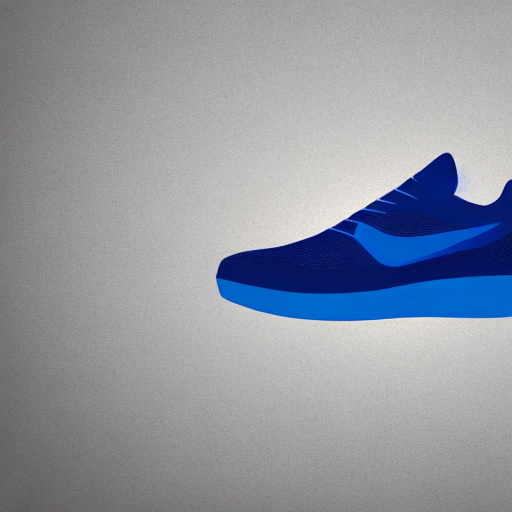

Prompt: flat-lay of a ceramic coffee mug on wooden desk, warm light, top view


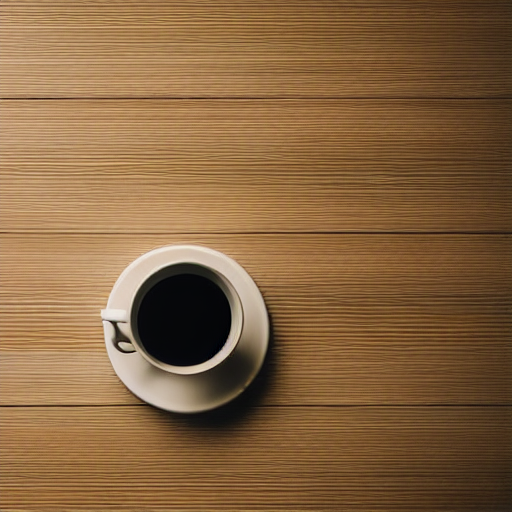

Prompt: vector-style icon of a delivery truck, blue and white, simple background


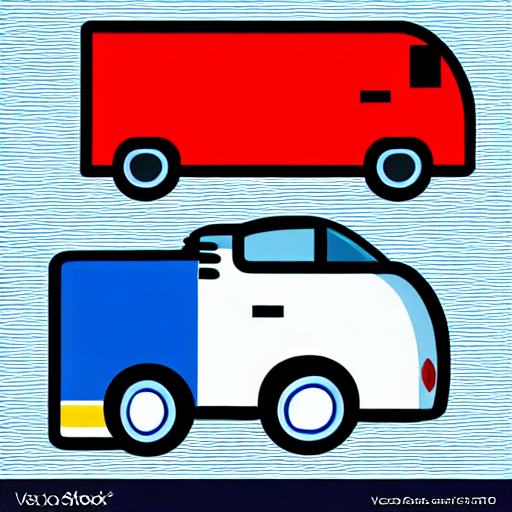

Prompt: a stack of three chocolate chip cookies on white plate, studio lighting


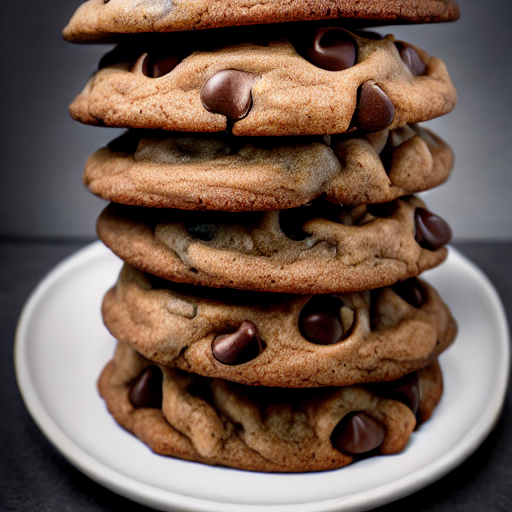

In [6]:
from IPython.display import display

def show_some_images(df, num=4):
    subset = df.head(num)
    for _, row in subset.iterrows():
        print("Prompt:", row["prompt"])
        display(Image.open(row["image_path"]))

show_some_images(baseline_df, num=4)


In [7]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model_id = "openai/clip-vit-base-patch32"

clip_model = CLIPModel.from_pretrained(clip_model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

print("Loaded CLIP model on", device)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Loaded CLIP model on cuda


In [8]:
import torch
from PIL import Image
from tqdm import tqdm

def compute_clip_scores(df, processor, model, device="cuda"):
    scores = []
    model.eval()

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing CLIP scores"):
            prompt = row["prompt"]
            image_path = row["image_path"]

            image = Image.open(image_path).convert("RGB")

            inputs = processor(
                text=[prompt],
                images=[image],
                return_tensors="pt",
                padding=True
            ).to(device)

            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

            clip_score = (image_embeds * text_embeds).sum(dim=-1).item()

            scores.append(clip_score)

    df_scores = df.copy()
    df_scores["clip_score"] = scores
    return df_scores

baseline_clip_df = compute_clip_scores(
    baseline_df,
    processor=clip_processor,
    model=clip_model,
    device=device
)

baseline_clip_df



Computing CLIP scores: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


id                                             prompt  \
0   0  minimalist poster of a blue running shoe on wh...   
1   1  flat-lay of a ceramic coffee mug on wooden des...   
2   2  vector-style icon of a delivery truck, blue an...   
3   3  a stack of three chocolate chip cookies on whi...   
4   4  a red backpack on a wooden chair near a window...   
5   5  a simple bar chart illustration, blue and oran...   

                                          image_path  seed  steps  guidance  \
0  /content/ga_final/results_baseline/baseline_00...    11     30       7.5   
1  /content/ga_final/results_baseline/baseline_01...    11     30       7.5   
2  /content/ga_final/results_baseline/baseline_02...    11     30       7.5   
3  /content/ga_final/results_baseline/baseline_03...    11     30       7.5   
4  /content/ga_final/results_baseline/baseline_04...    11     30       7.5   
5  /content/ga_final/results_baseline/baseline_05...    11     30       7.5   

   height  width  clip_score  
0     512    512    0.292819  
1     512    512    0.296194  
2     512    512    0.346756  
3     512    512    0.356809  
4     512    512    0.344990  
5     512    512    0.226040

In [9]:
baseline_mean = baseline_clip_df["clip_score"].mean()
print("Baseline mean CLIPScore:", baseline_mean)


Baseline mean CLIPScore: 0.3106013387441635


In [10]:
!pip install -q "datasets<3.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [11]:
from datasets import load_dataset

raw_dataset = load_dataset("cifar10")

train_dataset = raw_dataset["train"].select(range(5000))

label_names = raw_dataset["train"].features["label"].names
print(label_names)

len(train_dataset), train_dataset[0]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(5000,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 0})

In [12]:
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

image_transform = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [13]:
image_transform = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [14]:
from diffusers import StableDiffusionPipeline, DDPMScheduler
import torch

model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
)
pipe.to(device)
pipe.enable_attention_slicing()

unet = pipe.unet
text_encoder = pipe.text_encoder
vae = pipe.vae

noise_scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

print("Pipe, UNet, VAE, and training scheduler re-initialized.")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipe, UNet, VAE, and training scheduler re-initialized.


In [15]:
for p in unet.parameters():
    p.requires_grad_(False)
for p in text_encoder.parameters():
    p.requires_grad_(False)
for p in vae.parameters():
    p.requires_grad_(False)

trainable_params = []
for name, module in unet.named_modules():
    if "attn2" in name:
        for p in module.parameters():
            p.requires_grad_(True)
            trainable_params.append(p)

print("Trainable tensors:", len(trainable_params))
print("Total trainable params:", sum(p.numel() for p in trainable_params))


Trainable tensors: 192
Total trainable params: 100328000


In [16]:
from torch.utils.data import Dataset, DataLoader

tokenizer = pipe.tokenizer
label_names = label_names

class CifarCaptionDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, label_names, max_length=32):
        self.ds = hf_dataset
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.max_length = max_length

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]


        image = item["img"]


        label_id = int(item["label"])
        label_name = self.label_names[label_id]
        caption = f"a photo of a {label_name}"


        pixel_values = image_transform(image)


        encoded = self.tokenizer(
            caption,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )

        input_ids = encoded.input_ids[0]
        attention_mask = encoded.attention_mask[0]

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }


train_ti_dataset = CifarCaptionDataset(
    train_dataset,
    tokenizer=tokenizer,
    label_names=label_names,
)

train_dataloader = DataLoader(
    train_ti_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

len(train_ti_dataset)

5000

In [17]:
unet = pipe.unet
text_encoder = pipe.text_encoder
vae = pipe.vae


for p in unet.parameters():
    p.requires_grad_(False)
for p in text_encoder.parameters():
    p.requires_grad_(False)
for p in vae.parameters():
    p.requires_grad_(False)


trainable_params = []
for name, module in unet.named_modules():
    if "attn2" in name:
        for p in module.parameters():
            p.requires_grad_(True)
            trainable_params.append(p)

print("trainnable parameter tensors numbers:", len(trainable_params))
print("Total:", sum(p.numel() for p in trainable_params))


trainnable parameter tensors numbers: 192
Total: 100328000


In [18]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
unet.to(device)
text_encoder.to(device)
vae.to(device)


optimizer = torch.optim.AdamW(trainable_params, lr=1e-6)


num_epochs = 1
max_train_steps = 400
log_every = 50

global_step = 0

/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


In [19]:
import torch, gc


try:
    clip_model.to("cpu")
except NameError:
    pass


torch.cuda.empty_cache()
gc.collect()
print("Moved CLIP to CPU and cleared CUDA cache.")

Moved CLIP to CPU and cleared CUDA cache.


In [20]:
import torch
torch.cuda.empty_cache()
print("CUDA cache cleared again.")

CUDA cache cleared again.


In [21]:
from tqdm.auto import tqdm
import torch

unet.train()

nan_happened = False

for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in pbar:
        global_step += 1
        if global_step > max_train_steps:
            break


        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)


        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * 0.18215


        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bsz,),
            device=device, dtype=torch.long
        )
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)


        with torch.no_grad():
            encoder_hidden_states = text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )[0]


        noise_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states
        ).sample


        loss = F.mse_loss(noise_pred.float(), noise.float())


        if not torch.isfinite(loss):
            print(f"\n[WARN] loss when {loss.item()} at step={global_step}，stop trainning.")
            nan_happened = True
            break

        optimizer.zero_grad()
        loss.backward()


        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)

        optimizer.step()

        if global_step % log_every == 0:
            pbar.set_postfix({"loss": float(loss.item()), "step": global_step})

    if global_step > max_train_steps or nan_happened:
        break

print("Training finished. Total steps:", global_step)

Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]


[WARN] loss when nan at step=2，stop trainning.
Training finished. Total steps: 2


In [22]:
import os, torch

PROJECT_ROOT = "/content/ga_final"
os.makedirs(PROJECT_ROOT, exist_ok=True)

FT_UNET_PATH = os.path.join(PROJECT_ROOT, "unet_finetuned_step400.pth")
torch.save(unet.state_dict(), FT_UNET_PATH)
print("✓ Fine-tuned UNet saved to:", FT_UNET_PATH)

✓ Fine-tuned UNet saved to: /content/ga_final/unet_finetuned_step400.pth


In [23]:
import os
import torch
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"


cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

prompts = []
for cls in cifar10_classes:
    for i in range(5):
        prompts.append(f"a photo of a {cls}")

print("Number of prompts:", len(prompts))
print("Example prompts:", prompts[:5])


def generate_images_with_pipe(
    pipe,
    prompts,
    out_dir,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=256,
    width=256,
    seed=11,
):

    os.makedirs(out_dir, exist_ok=True)
    generator = torch.Generator(device).manual_seed(seed)

    records = []
    pipe.to(device)

    for i, prompt in enumerate(tqdm(prompts, desc=f"Generating in {out_dir}")):
        with torch.autocast(device_type=device, dtype=torch.float16):
            image = pipe(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=height,
                width=width,
                generator=generator,
            ).images[0]

        filename = f"img_{i:02d}.png"
        save_path = os.path.join(out_dir, filename)
        image.save(save_path)

        records.append(
            {
                "id": i,
                "prompt": prompt,
                "image_path": save_path,
                "steps": num_inference_steps,
                "guidance": guidance_scale,
                "height": height,
                "width": width,
                "seed": seed,
            }
        )

    df = pd.DataFrame(records)
    csv_path = os.path.join(out_dir, "metadata.csv")
    df.to_csv(csv_path, index=False)
    print("✓ Saved metadata to:", csv_path)
    return df

Number of prompts: 50
Example prompts: ['a photo of a airplane', 'a photo of a airplane', 'a photo of a airplane', 'a photo of a airplane', 'a photo of a airplane']


In [24]:
import gc, torch

for name in ["pipe", "unet", "text_encoder", "vae", "noise_scheduler"]:
    if name in globals():
        del globals()[name]

torch.cuda.empty_cache()
gc.collect()

print("GPU memory cleared.")

GPU memory cleared.


In [25]:
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

base_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
base_pipe.safety_checker = None
base_pipe.enable_attention_slicing()

BASE_DIR = os.path.join(PROJECT_ROOT, "results_baseline")
baseline_df = generate_images_with_pipe(base_pipe, prompts, BASE_DIR)

del base_pipe
torch.cuda.empty_cache()

baseline_df.head()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating in /content/ga_final/results_baseline:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved metadata to: /content/ga_final/results_baseline/metadata.csv


id                 prompt                                     image_path  \
0   0  a photo of a airplane  /content/ga_final/results_baseline/img_00.png   
1   1  a photo of a airplane  /content/ga_final/results_baseline/img_01.png   
2   2  a photo of a airplane  /content/ga_final/results_baseline/img_02.png   
3   3  a photo of a airplane  /content/ga_final/results_baseline/img_03.png   
4   4  a photo of a airplane  /content/ga_final/results_baseline/img_04.png   

   steps  guidance  height  width  seed  
0     30       7.5     256    256    11  
1     30       7.5     256    256    11  
2     30       7.5     256    256    11  
3     30       7.5     256    256    11  
4     30       7.5     256    256    11

In [26]:
from diffusers import StableDiffusionPipeline

ft_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
ft_pipe.safety_checker = None
ft_pipe.enable_attention_slicing()

state_dict = torch.load(FT_UNET_PATH, map_location=device)
ft_pipe.unet.load_state_dict(state_dict, strict=False)
print("✓ Loaded fine-tuned UNet into pipeline.")

FT_DIR = os.path.join(PROJECT_ROOT, "results_finetuned")
ft_df = generate_images_with_pipe(ft_pipe, prompts, FT_DIR)

ft_df.head()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ Loaded fine-tuned UNet into pipeline.


Generating in /content/ga_final/results_finetuned:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/image_processor.py:111: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved metadata to: /content/ga_final/results_finetuned/metadata.csv


id                 prompt                                      image_path  \
0   0  a photo of a airplane  /content/ga_final/results_finetuned/img_00.png   
1   1  a photo of a airplane  /content/ga_final/results_finetuned/img_01.png   
2   2  a photo of a airplane  /content/ga_final/results_finetuned/img_02.png   
3   3  a photo of a airplane  /content/ga_final/results_finetuned/img_03.png   
4   4  a photo of a airplane  /content/ga_final/results_finetuned/img_04.png   

   steps  guidance  height  width  seed  
0     30       7.5     256    256    11  
1     30       7.5     256    256    11  
2     30       7.5     256    256    11  
3     30       7.5     256    256    11  
4     30       7.5     256    256    11

In [27]:
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"


def dummy_safety_checker(images, clip_input=None):

    if isinstance(images, list):
        batch_size = len(images)
    else:
        batch_size = images.shape[0]
    return images, [False] * batch_size


base_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
).to(device)

base_pipe.safety_checker = dummy_safety_checker
base_pipe.enable_attention_slicing()


ft_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
).to(device)

ft_pipe.safety_checker = dummy_safety_checker
ft_pipe.enable_attention_slicing()


state_dict = torch.load(FT_UNET_PATH, map_location=device)
ft_pipe.unet.load_state_dict(state_dict, strict=False)
print("✓ Loaded fine-tuned UNet into pipeline（safety checker off）.")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ Loaded fine-tuned UNet into pipeline（safety checker off）.


In [28]:
from transformers import CLIPProcessor, CLIPModel

clip_device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to(clip_device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)


def compute_clip_scores(df, processor, model, device, batch_size=8):
    all_scores = []
    model.eval()
    with torch.no_grad():
        for start in range(0, len(df), batch_size):
            batch = df.iloc[start:start + batch_size]
            images = [Image.open(p).convert("RGB") for p in batch["image_path"]]
            texts = batch["prompt"].tolist()

            inputs = processor(
                text=texts,
                images=images,
                return_tensors="pt",
                padding=True,
            ).to(device)

            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            # cosine similarity
            image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
            text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
            scores = (image_embeds * text_embeds).sum(dim=-1)

            all_scores.extend(scores.cpu().tolist())

    out_df = df.copy()
    out_df["clip_score"] = all_scores
    return out_df


baseline50_clip_df = compute_clip_scores(baseline_df, clip_processor, clip_model, clip_device)
ft50_clip_df       = compute_clip_scores(ft_df,        clip_processor, clip_model, clip_device)

baseline50_mean = baseline50_clip_df["clip_score"].mean()
ft50_mean       = ft50_clip_df["clip_score"].mean()

print("Baseline(50) mean CLIPScore:", baseline50_mean)
print("Finetuned(50) mean CLIPScore:", ft50_mean)


def extract_class(prompt: str) -> str:
    # "a photo of a cat" -> "cat"
    return prompt.split("of a")[-1].strip()

baseline50_clip_df["class"] = baseline50_clip_df["prompt"].apply(extract_class)
ft50_clip_df["class"]       = ft50_clip_df["prompt"].apply(extract_class)

class_stats = (
    baseline50_clip_df[["class", "clip_score"]]
      .groupby("class").mean()
      .rename(columns={"clip_score": "baseline_clip"})
      .merge(
          ft50_clip_df[["class", "clip_score"]]
            .groupby("class").mean()
            .rename(columns={"clip_score": "finetuned_clip"}),
          on="class"
      )
      .reset_index()
)

print("\nPer-class CLIPScore (baseline vs finetuned):")
class_stats

Baseline(50) mean CLIPScore: 0.24200711905956268
Finetuned(50) mean CLIPScore: 0.2442682722210884

Per-class CLIPScore (baseline vs finetuned):


class  baseline_clip  finetuned_clip
0    airplane       0.234602        0.241020
1  automobile       0.258954        0.244351
2        bird       0.251794        0.249373
3         cat       0.243986        0.246230
4        deer       0.257370        0.238309
5         dog       0.218826        0.251883
6        frog       0.239320        0.238539
7       horse       0.224263        0.249182
8        ship       0.253262        0.246546
9       truck       0.237695        0.237249

In [29]:
!ls -R /content | head -n 50


/content:
ga_final
sample_data

/content/ga_final:
results_baseline
results_finetuned
unet_finetuned_step400.pth

/content/ga_final/results_baseline:
baseline_00.png
baseline_01.png
baseline_02.png
baseline_03.png
baseline_04.png
baseline_05.png
baseline_metadata.csv
img_00.png
img_01.png
img_02.png
img_03.png
img_04.png
img_05.png
img_06.png
img_07.png
img_08.png
img_09.png
img_10.png
img_11.png
img_12.png
img_13.png
img_14.png
img_15.png
img_16.png
img_17.png
img_18.png
img_19.png
img_20.png
img_21.png
img_22.png
img_23.png
img_24.png
img_25.png
img_26.png
img_27.png
img_28.png
img_29.png
img_30.png
img_31.png
img_32.png


In [31]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
!mkdir -p /content/drive/MyDrive/stable_diffusion_outputs/baseline
!mkdir -p /content/drive/MyDrive/stable_diffusion_outputs/finetuned

!cp -r /content/ga_final/results_baseline/* /content/drive/MyDrive/stable_diffusion_outputs/baseline/
!cp -r /content/ga_final/results_finetuned/* /content/drive/MyDrive/stable_diffusion_outputs/finetuned/


In [33]:
!ls /content


drive  ga_final  sample_data


In [34]:
!find /content -type d -name "*result*"


/content/ga_final/results_finetuned
/content/ga_final/results_baseline


In [35]:
!find /content -type f -name "*.png" | head -n 50


/content/drive/MyDrive/beacon/9cb44a9f8d04fb48dbbe1cc75bd40f63.png
/content/drive/MyDrive/beacon/89b43e22a49f7fbb1d1cee1600259688.png
/content/drive/MyDrive/beacon/1f27aed7a253e1e597daaf442002356d.png
/content/drive/MyDrive/beacon/e10ade444762083e8b463fd2a90d90c0.png
/content/drive/MyDrive/beacon/6383ead13fc447ab8abc862b44836063.png
/content/drive/MyDrive/beacon/04153ea98927e2648bbea1391dcd2348.png
/content/drive/MyDrive/beacon/6880bcd662f810621b0e65713e7df5e3.png
/content/drive/MyDrive/1.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1/valid_image_0.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1/valid_image_1.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1/valid_image_2.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1000/valid_image_0.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1000/valid_image_1.png
/content/drive/MyDrive/ECE592_HW3/name/logs/checkpoint-1000/valid_image_2.png
/content/drive/MyDrive/ECE592_HW3/name/logs

In [36]:
import os, glob, math
from PIL import Image

def make_grid(input_dir, out_path, n_cols=10):

    files = sorted(glob.glob(os.path.join(input_dir, "img_*.png")))

    if len(files) == 0:
        raise ValueError(f"No images found in {input_dir}")


    w, h = Image.open(files[0]).size
    n = len(files)
    n_rows = math.ceil(n / n_cols)

    grid = Image.new("RGB", (n_cols * w, n_rows * h), "white")

    for idx, f in enumerate(files):
        img = Image.open(f).convert("RGB")
        r = idx // n_cols
        c = idx % n_cols
        grid.paste(img, (c * w, r * h))

    grid.save(out_path)
    print("Saved grid to:", out_path)


base_dir = "/content/ga_final/results_baseline"
ft_dir   = "/content/ga_final/results_finetuned"


make_grid(base_dir, "/content/baseline_grid.png",  n_cols=10)
make_grid(ft_dir,   "/content/finetuned_grid.png", n_cols=10)


Saved grid to: /content/baseline_grid.png
Saved grid to: /content/finetuned_grid.png


In [37]:
from PIL import Image
import os
import glob

def make_grid_from_dir(img_dir, out_path, grid_cols=10, grid_rows=5, img_size=(256, 256)):

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
    print(f"Found {len(img_paths)} images in {img_dir}")
    if len(img_paths) == 0:
        raise ValueError("Nothing")


    img_paths = img_paths[: grid_rows * grid_cols]


    images = [Image.open(p).convert("RGB").resize(img_size) for p in img_paths]

    w, h = img_size
    grid_w = grid_cols * w
    grid_h = grid_rows * h
    canvas = Image.new("RGB", (grid_w, grid_h), color="black")

    for idx, img in enumerate(images):
        r = idx // grid_cols
        c = idx % grid_cols
        canvas.paste(img, (c * w, r * h))

    canvas.save(out_path)
    print("Saved grid to:", out_path)



base_dir = "/content/ga_final/results_baseline"
ft_dir   = "/content/ga_final/results_finetuned"

os.makedirs("figs", exist_ok=True)

make_grid_from_dir(base_dir, "figs/baseline_grid.png",  grid_cols=10, grid_rows=5)
make_grid_from_dir(ft_dir,   "figs/finetuned_grid.png", grid_cols=10, grid_rows=5)


Found 56 images in /content/ga_final/results_baseline
Saved grid to: figs/baseline_grid.png
Found 50 images in /content/ga_final/results_finetuned
Saved grid to: figs/finetuned_grid.png


In [39]:
#(Optional / Future work) Attempted to integrate LoRA fine-tuning, but the course environment's `diffusers` version exposes a `LoRAAttnProcessor` API that is incompatible with the standard pipeline integration (no `__call__`, not an `nn.Module`, and no accessible LoRA parameters via `named_parameters()`). Due to time and environment constraints, we report LoRA as planned future work instead of a fully working implementation.

import os, gc, torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.attention_processor import LoRAAttnProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

for name in ["pipe", "base_pipe", "ft_pipe", "unet", "text_encoder", "vae", "noise_scheduler"]:
    if name in globals():
        del globals()[name]
torch.cuda.empty_cache()
gc.collect()
print("✓ Cleared old pipelines from GPU.")

model_id = "runwayml/stable-diffusion-v1-5"

lora_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)

lora_pipe.scheduler = DPMSolverMultistepScheduler.from_config(lora_pipe.scheduler.config)

unet = lora_pipe.unet

lora_rank = 4
lora_attn_procs = {}

for name in unet.attn_processors.keys():
    if name.endswith("attn1.processor"):
        cross_attention_dim = None
    else:
        cross_attention_dim = unet.config.cross_attention_dim

    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name.split(".")[1])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name.split(".")[1])
        hidden_size = unet.config.block_out_channels[block_id]
    else:
        continue

    lora_attn_procs[name] = LoRAAttnProcessor()

unet.set_attn_processor(lora_attn_procs)
print("✓ LoRA processors set on UNet.")

for p in unet.parameters():
    p.requires_grad_(False)

lora_params = []
for name, p in unet.named_parameters():
    if "lora" in name.lower():
        p.requires_grad_(True)
        lora_params.append(p)

print("Trainable LoRA parameter count:", sum(p.numel() for p in lora_params))

if len(lora_params) == 0:
    print("[WARN] No LoRA")
else:
    optimizer = torch.optim.AdamW(lora_params, lr=1e-4)

lora_max_steps = 300
log_every = 50

global_step = 0
unet.train()

pbar = tqdm(range(lora_max_steps), desc="LoRA training")
train_iter = iter(train_dataloader)

while global_step < lora_max_steps:
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_dataloader)
        batch = next(train_iter)

    global_step += 1

    pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
    input_ids = batch["input_ids"].to(device)

    with torch.no_grad():
        latents = lora_pipe.vae.encode(pixel_values).latent_dist.sample()
        latents = latents * 0.18215

    noise = torch.randn_like(latents)
    timesteps = torch.randint(
        0, lora_pipe.scheduler.config.num_train_timesteps,
        (latents.shape[0],), device=device, dtype=torch.long
    )
    noisy_latents = lora_pipe.scheduler.add_noise(latents, noise, timesteps)


    with torch.no_grad():
        encoder_hidden_states = lora_pipe.text_encoder(input_ids)[0]


    with torch.autocast(device_type="cuda", dtype=torch.float16):
        noise_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states,
        ).sample
        loss = F.mse_loss(noise_pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if global_step % log_every == 0:
        pbar.set_postfix({"loss": float(loss.item())})
    pbar.update(1)

print("LoRA training finished. Total steps:", global_step)

LORA_UNET_PATH = os.path.join(PROJECT_ROOT, "unet_lora.pth")
torch.save(unet.state_dict(), LORA_UNET_PATH)
print("✓ LoRA UNet weights saved to:", LORA_UNET_PATH)


✓ Cleared old pipelines from GPU.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ LoRA processors set on UNet.
Trainable LoRA parameter count: 0
[WARN] No LoRA


LoRA training:   0%|          | 0/300 [00:00<?, ?it/s]

AttributeError: 'LoRAAttnProcessor' object has no attribute '__call__'

In [ ]:
from diffusers import StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

lora_gen_pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
lora_gen_pipe.enable_attention_slicing()

unet = lora_gen_pipe.unet
unet.set_attn_processor(lora_attn_procs)
state_dict = torch.load(LORA_UNET_PATH, map_location=device)
unet.load_state_dict(state_dict, strict=False)
print("✓ Loaded LoRA UNet into generation pipeline.")

LORA_DIR = os.path.join(PROJECT_ROOT, "results_lora")
lora_df = generate_images_with_pipe(lora_gen_pipe, prompts, LORA_DIR)

lora_df.head()

In [ ]:
lora_clip_df = compute_clip_scores(lora_df, clip_processor, clip_model, clip_device)
lora_mean = lora_clip_df["clip_score"].mean()
print("LoRA(50) mean CLIPScore:", lora_mean)

summary_df = pd.DataFrame({
    "model": ["baseline", "finetuned", "lora"],
    "mean_clip_score": [baseline50_mean, ft50_mean, lora_mean],
})
summary_df